In [16]:
ib.disconnect()

In [1]:
from ib_insync import *
from matplotlib import pyplot as plt
import mplfinance as mpf
import datetime
from dateutil import tz
import pytz
tz_ams = pytz.timezone('Europe/Amsterdam')
tz_ny = pytz.timezone('America/New_York')

def mpf_prep(df):
    df = df.copy(deep=True)
    df = df.set_index("date")
    df = df.rename(columns={col:col[0].upper()+col[1:] for col in df.columns})
    return df

In [2]:
util.startLoop()

In [3]:
ib = IB()
ib.connect(
	'127.0.0.1',
	4002, # TWS=7496, GTW=4001, # PAPER=7497
	clientId=2
)

<IB connected to 127.0.0.1:4002 clientId=2>

In [4]:
[v for v in ib.accountValues() if v.tag == 'NetLiquidationByCurrency' and v.currency == 'BASE']

[AccountValue(account='DU1762566', tag='NetLiquidationByCurrency', value='922859.1761', currency='BASE', modelCode='')]

In [5]:
p = ib.portfolio()
p

[PortfolioItem(contract=Future(conId=357283364, symbol='ES', lastTradeDateOrContractMonth='20200619', right='0', multiplier='50', primaryExchange='GLOBEX', currency='USD', localSymbol='ESM0', tradingClass='ES'), position=2.0, marketPrice=2994.25, marketValue=299425.0, averageCost=146353.2909, unrealizedPNL=6718.42, realizedPNL=0.0, account='DU1762566')]

In [6]:
# reqMktDataType(#)
# 1. Live Data
# 2. Frozen
# 3. Delayed
# 4. Delayed - Frozen
ib.reqMarketDataType(1)

## Mkt Depth Strat

In [20]:
l = ib.reqMktDepthExchanges()

In [38]:
# cs = ib.reqContractDetails(Future(symbol='ES', exchange='GLOBEX'))
cs = ib.reqContractDetails(Future("MGC", exchange="NYMEX"))
print(len(cs))
contract = cs[0].contract
contract

11


Contract(secType='FUT', conId=335154400, symbol='MGC', lastTradeDateOrContractMonth='20200827', multiplier='10', exchange='NYMEX', currency='USD', localSymbol='MGCQ0', tradingClass='MGC')

In [39]:
bars = ib.reqHistoricalData(
        contract,
        endDateTime=datetime.datetime.now(),
        durationStr='20 D',
        barSizeSetting='1 hour', # '1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=2 # UTC
)
bars = util.df(bars)
bars = mpf_prep(bars)

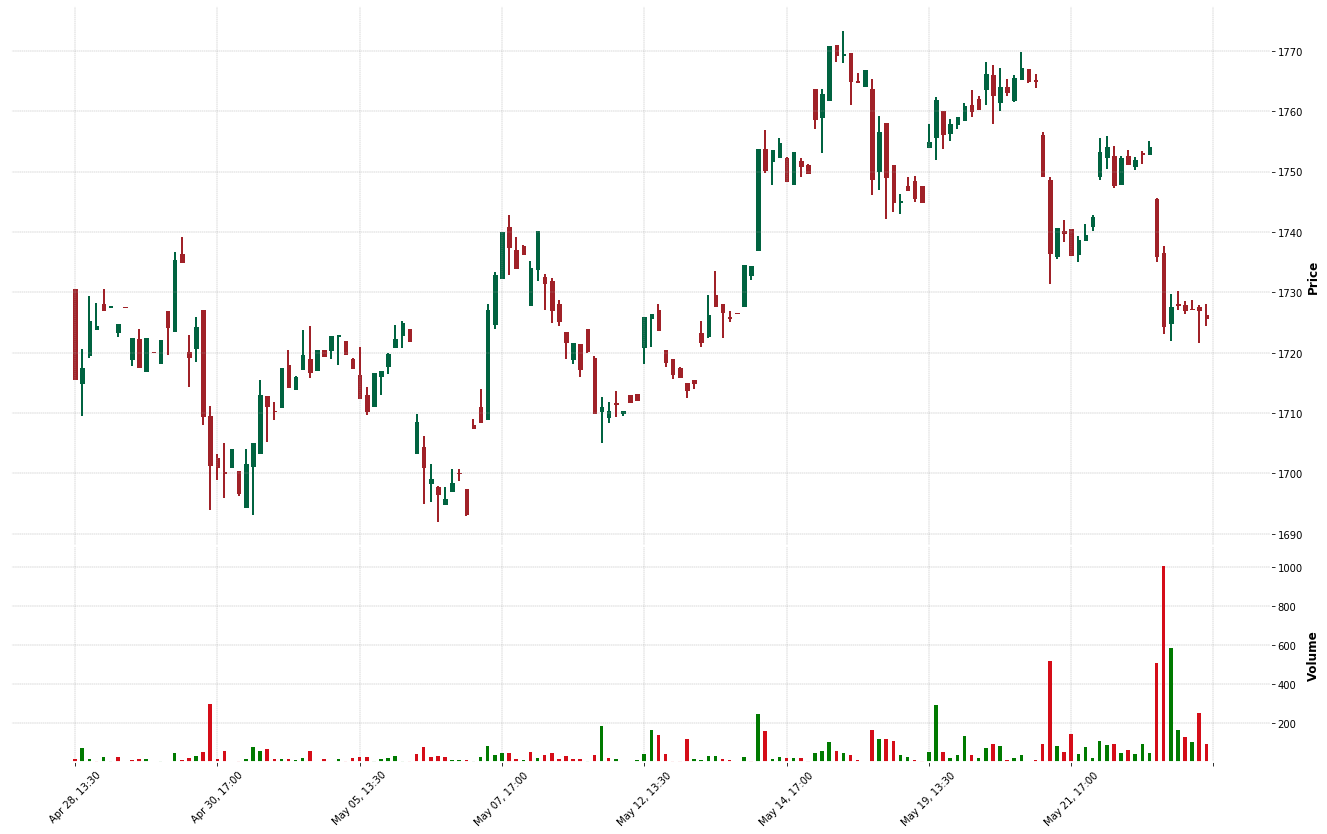

In [40]:
mpf.plot(bars, type='candle', volume=True, figratio=(25,15), style='charles')

In [256]:
esbars.index=esbars.index.map(lambda x: tz_ams.localize(x).astimezone(tz_ny).replace(tzinfo=None).replace(second=0, microsecond=0))
tickers.index=tickers.index.map(lambda x: tz_ams.localize(x).astimezone(tz_ny).replace(tzinfo=None).replace(second=0, microsecond=0))

In [284]:
largeorders = esbars.join(
    tickers[tickers["size"]>=100],
    how="left"
)
largeorders["sell"]=largeorders.apply(lambda x: x["price"] if (x["price"]>x["High"]-0.5) else None, axis=1)
largeorders["buy"]=largeorders.apply(lambda x: x["price"] if (x["price"]<x["Low"]+0.5) else None, axis=1)

In [290]:
largeorders1=largeorders.groupby(largeorders.index).nth(0)
largeorders2=esbars.join(largeorders.groupby(largeorders.index).nth(1)[["sell","buy", "size"]], how="left")

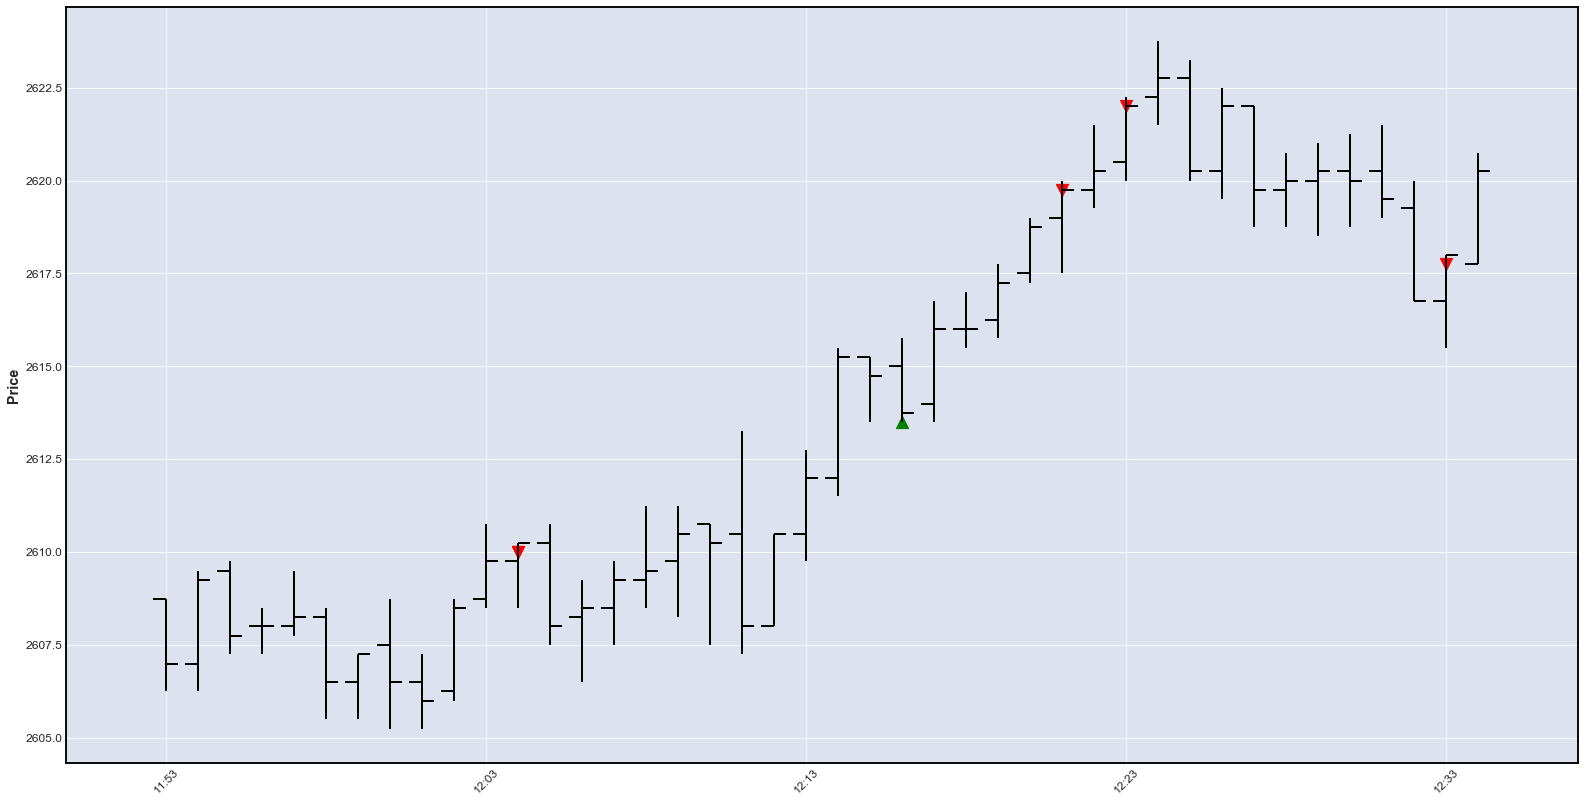

In [295]:
mpf.plot(
    esbars, 
    volume=False, 
    figratio=(30,15), 
    #style='charles', 
    addplot=[
        mpf.make_addplot(
            largeorders1["buy"],
            scatter=True,
            markersize=150,
            marker='^',
            color="green"
        ),
        mpf.make_addplot(
            largeorders1["sell"],
            scatter=True,
            markersize=150,
            marker='v',
            color='red'
        ),
        mpf.make_addplot(
            largeorders2["sell"],
            scatter=True,
            markersize=150,
            marker='v',
            color='red'
        )    
    ],
)